In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as vutils

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
batch_size = 64

workers = 10

traintransform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,], [0.5,])])
preproccess = transforms.Compose([transforms.Normalize([0.5,], [0.5,])])

testtransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,], [0.5,])])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=traintransform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=testtransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=workers)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


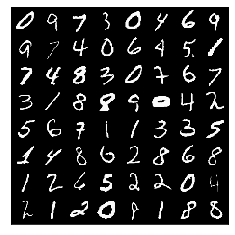

In [4]:
image, label = next(iter(trainloader))

def plot_img(array,number=None):
    array = array.detach()
    array = array.reshape(28,28)
    
    plt.imshow(array,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if number:
        plt.xlabel(number,fontsize='x-large')
    plt.show()
    
    
def plot_imgs(imgs):
    imgs = imgs.detach()
    imgs = imgs.view(-1, 1, 28,28)
    
    stack_imgs = vutils.make_grid(imgs, nrow=8)
    
    plt.imshow(stack_imgs.permute(1, 2, 0),cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
plot_imgs(image)


In [5]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, feats):
        super(Generator, self).__init__()
        self.feats = feats
        
        self.conv1 = nn.Conv2d(1, feats * 4, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(feats*4, feats*2, kernel_size=2, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(feats * 2)
        
        #self.conv3 = nn.Conv2d(feats*4, feats*2, kernel_size=3, stride=1, padding=1)
        #self.batch_norm2 = nn.BatchNorm2d(feats * 2)
        
        self.conv4 = nn.Conv2d(feats*2, feats, kernel_size=2, stride=2, padding=1)
        
        self.linear1 = nn.Linear(feats, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 10, 10)
        x = F.relu(self.conv1(x))
        
        x = self.conv2(x)
        x = F.relu(self.batch_norm1(x))
        
        #x = F.relu(self.batch_norm2(self.conv3(x)))
        
        x = F.relu(self.conv4(x))
        
        x = x.view(-1, self.feats)
        x = F.relu(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, feats):
        super(Discriminator, self).__init__()
        self.feats = feats
        
        self.conv1 = nn.Conv2d(1, feats, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(feats, feats*2, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(feats * 2)
        
        #self.conv3 = nn.Conv2d(feats*2, feats*4, kernel_size=3, stride=1, padding=2)
        #self.batch_norm2 = nn.BatchNorm2d(feats * 4)
        
        self.conv4 = nn.Conv2d(feats*2, feats*4, kernel_size=2, stride=1, padding=1)
        
        self.linear1 = nn.Linear(feats*4, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.batch_norm1(self.conv2(x)))
        
        #x = F.relu(self.batch_norm2(self.conv3(x)))
        
        x = F.relu(self.conv4(x))
        
        x = x.view(-1, self.feats*4)
        x = F.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
G = Generator(input_size=100,
                  hidden_size=256,
                  output_size=28*28,
                  feats=10)
D = Discriminator(input_size=28*28,
                  hidden_size=256,
                  output_size=1,
                  feats=10)
G.to(device)
D.to(device)

Discriminator(
  (conv1): Conv2d(1, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=40, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
d_learning_rate = 1e-3
g_learning_rate = 1e-3
sgd_momentum = 0.9

criterion = nn.BCELoss()
#d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
#d_optimizer.zero_grad()
#g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)
#g_optimizer.zero_grad()

lr = 0.0002 
g_optimizer = optim.Adam(G.parameters(), lr = lr)
d_optimizer = optim.Adam(D.parameters(), lr = lr)

epoch= 0
g loss= 1.2355891633262512
d loss= 1.9595003423533206


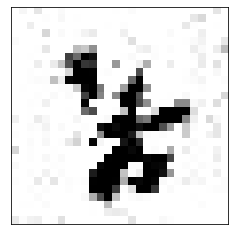

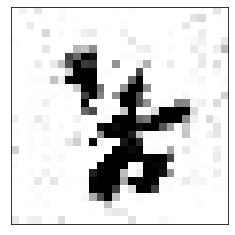

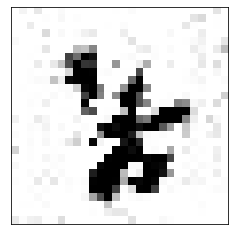

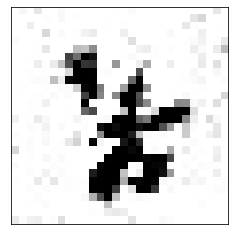

KeyboardInterrupt: 

In [9]:
epochs = 100
printing_steps = 10

for e in range(epochs):
    running_g_loss = 0
    running_d_loss = 0
    for real_image, _ in trainloader:
        # Discrim Train
        D.zero_grad()
        real_image = real_image.to(device)
        real_out = D(real_image)
        dis_real_loss = criterion(real_out, Variable(torch.ones(real_out.shape[0], 1)).to(device))
        running_d_loss += dis_real_loss.item()
        
        fake_image_in = torch.randn(batch_size,100).to(device)
        fake_image = G(fake_image_in)
        fake_out = D(fake_image.view(-1, 28, 28))
        fake_loss = criterion(fake_out, Variable(torch.zeros(fake_out.shape[0], 1)).to(device))
        #print(fake_loss)
        running_d_loss += fake_loss.item()
        
        loss = dis_real_loss + fake_loss
        loss.backward()
        d_optimizer.step()

        # Generator Training
        G.zero_grad()
        
        generator_input = torch.randn(batch_size, 100).to(device)
        
        gen_out = G(generator_input)
        dis_out_gen_train = D(gen_out.view(-1, 28, 28))
        #print(dis_out_gen_train[:10])
        gen_loss = criterion(dis_out_gen_train, Variable(torch.ones(dis_out_gen_train.shape[0], 1)).to(device))
        running_g_loss += gen_loss.item()
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        gen_loss.backward()
        g_optimizer.step()
    if e%printing_steps == 0:
        print(f'epoch= {e}')
        print(f'g loss= {running_g_loss / len(trainloader)}')
        print(f'd loss= {running_d_loss / len(trainloader) * 2}')
        plot_img(gen_out[0].cpu())
        plot_img(gen_out[1].cpu())
        plot_img(gen_out[2].cpu())
        plot_img(gen_out[3].cpu())
        print("\n\n")

In [ ]:
G.eval()

#print("fake images")
with torch.no_grad():
    generator_input = torch.randn(batch_size, 100).to(device)
    gen_out = G(generator_input).cpu()
    plot_imgs(gen_out)

#print("real images")
image, label = next(iter(trainloader))
plot_imgs(image)

#print("blended images")
gen_out = gen_out.view(-1, 1, 28, 28)
combined = torch.cat((gen_out, image), dim=0)
np.random.shuffle(combined)

plot_imgs(combined[:64])

In [ ]:
image.shape

In [ ]:
D_PATH = 'mnist_dcgan_D.pwf'
torch.save(D.state_dict(), D_PATH)
G_PATH = 'mnist_dcgan_G.pwf'
torch.save(G.state_dict(), G_PATH)

In [ ]:
D_PATH = 'mnist_dcgan_D.pwf'
D.load_state_dict(torch.load(D_PATH))
G_PATH = 'mnist_dcgan_G.pwf'
G.load_state_dict(torch.load(G_PATH))